# Análise Exploratória de Avaliação de Produtos

O objetivo principal deste projeto é apontar quais marcas de instrumentos musicais, possuem melhor avaliação.


*   As avaliações podem ser medidas de 5 (nota máxima) até 1 (nota mínima).
*   Dados foram coletados via API do Kaggle em formato JSON.
*   Dataset disponível em: https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews
*   Para este projeto, foi utilizado PySpark, SQL e Pandas.

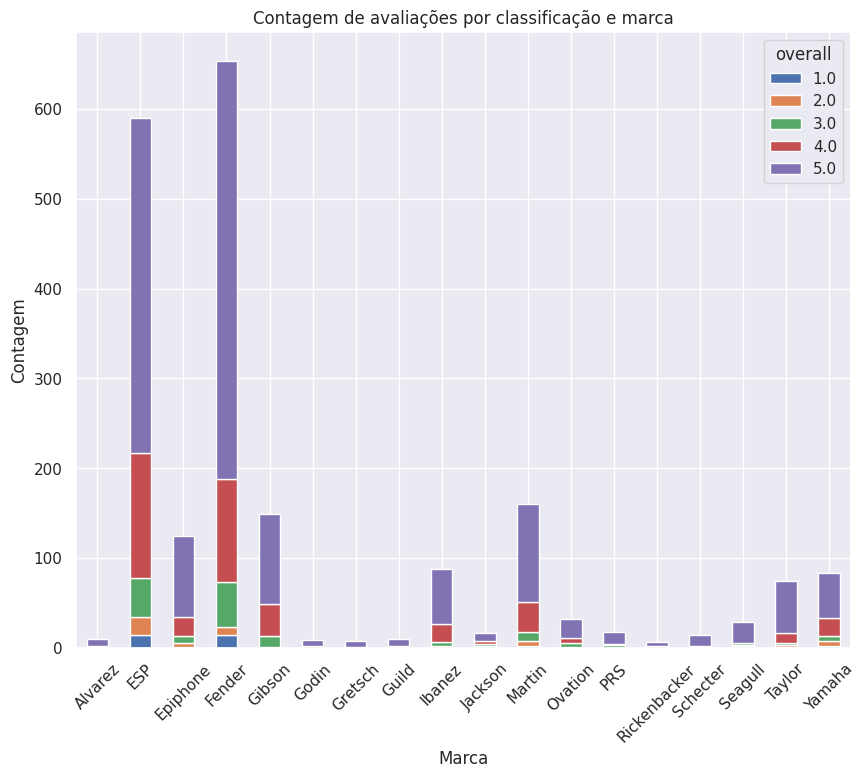

# Código

# Sobre os dados do dataset (colunas)
*   
reviewerID - ID do revisor, ex: A2SUAM1J3GNN3B
*   
asin - ID do produto, ex: 0000013714
*   
reviewerName - nome do revisor
*   
helpful - classificação de ajuda da análise, ex: 2/3
*   
reviewText - texto da análise
*   
overall - classificação do produto
*   
summary - resumo da análise
*   
unixReviewTime - tempo da análise (tempo Unix)
*   
reviewTime - tempo da análise (original)

In [1]:
#Mapear nosso Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.1//spark-3.3.1-bin-hadoop2.tgz
!tar xf spark-3.3.1-bin-hadoop2.tgz
!pip install -q findspark

In [3]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop2.7"

In [4]:
#importando biblioteca para reconhecer o pyspark
import findspark
findspark.init('spark-3.3.1-bin-hadoop2')

In [5]:
#escrevendo um arquivo no nosso Drive para testar o mapeamento
with open('/content/gdrive/My Drive/Colab Notebooks/testando_mount.txt', 'w') as f:
    f.write('content')

In [6]:
#Criando nossa primeira Sessão com o SparkSession
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Minha Primeira Aplicação no Pyspark") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()	

In [7]:
spark

In [8]:
#instalar extensão kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#importar biblioteca kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"igorpereirasilva","key":"932cad93df082ec0266d416f7e420cdd"}'}

In [10]:
#Mover o "kaggle.json" para o diretorio "/root/.kaggle/" no collab e conceder permissões:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
#importar biblioteca kaggle
import kaggle

In [12]:
#pathway até o dataset
kaggle.api.authenticate()
kaggle.api.dataset_download_files('eswarchandt/amazon-music-reviews', path='./data', unzip=True)

In [13]:
# ler o arquivo JSON baixado do Kaggle
dataset_raw = spark.read.json("./data/Musical_Instruments_5.json")

In [14]:
dataset_raw

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint]

In [15]:
#numero colunas e linhas
num_rows = dataset_raw.count()
num_cols = len(dataset_raw.columns)

In [16]:
print('Shape: ({}, {})'.format(num_rows, num_cols))

Shape: (10261, 9)


In [17]:
#colunas
dataset_raw.columns

['asin',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime']

In [18]:
#Tipo
type(dataset_raw)

pyspark.sql.dataframe.DataFrame

In [19]:
#Schema
dataset_raw.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [20]:
#Mostrar dataset
dataset_raw.show(truncate=True)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|
|1384719342|  [1, 1]|    5.0|The primary job o...|08 28, 2013|A195EZSQDW3E21|Rick Bennette "Ri...|It Does The Job Well|    1377648000|
|1384719342|  [0, 0]|    5.0|Nice windscreen p...|02 14, 2014|A2C00NNG1ZQQG2|RustyBill "Sunday...|GOOD WINDSCREEN F...|    1392336000|
|1384719342|  [0, 0]|    5.0|This pop filter i...|02 21

In [21]:
#Para manipular colunas, utilizamos os métodos .withColumn() e .withColumnRenamed()
#col > função que retorna um objeto de coluna do Pyspark DataFrame.
#lit > função que retorna um objeto de coluna do Pyspark DataFrame com um valor literal.

#Importar bibliotecas

from pyspark.sql.functions import col, lit

In [22]:
#Renomear coluna

df_1 = dataset_raw.withColumnRenamed("asin","ProductID")

In [58]:
#Adicionar colunas temporais
from pyspark.sql.functions import from_unixtime, date_format

# Adicionar coluna com formato '%Y-%m-%d %H:%M:%S'
df_2_ = df_1.withColumn('reviewDateTime', from_unixtime('unixReviewTime', 'yyyy-MM-dd HH:mm:ss'))

# Adicionar coluna com formato '%Y-%m-%d'
df_2_ = df_2_.withColumn('reviewDate', date_format('reviewDateTime', 'yyyy-MM-dd'))

# Adicionar coluna com formato YYYY
df_2_ = df_2_.withColumn('reviewYear', date_format('reviewDateTime', 'yyyy'))

# Adicionar coluna com formato '%Y-%m'
df_1 = df_2_.withColumn('reviewMonth', date_format('reviewDateTime', 'yyyy-MM'))

df_1.show(5)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+-----------+----------+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewMonth|reviewYear|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+-----------+----------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|2014-02-28 00:00:00|2014-02-28|    2014-02|      2014|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|    2013-03|      2013|
|1384719342|  [1, 1]|    5.0|The primary job o...|08 28

In [59]:
#Ordenando dados

from pyspark.sql.functions import asc,desc

df_1.orderBy(desc("overall")).show(5)

+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+-------------------+----------+-----------+----------+
| ProductID|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewMonth|reviewYear|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+-------------------+----------+-----------+----------+
|B003VWKPHC| [1, 1]|    5.0|My mother "plays"...| 09 6, 2011|A202CZ4PJH83G4|     Tinfoot|Even my mother lo...|    1315267200|2011-09-06 00:00:00|2011-09-06|    2011-09|      2011|
|B003VWKPHC| [0, 0]|    5.0|This is the secon...|05 17, 2011|A3P2J1W1RBUX6Q|     Tommy B|         Works Great|    1305590400|2011-05-17 00:00:00|2011-05-17|    2011-05|      2011|
|B003VWKPHC| [0, 1]|    5.0|This is a very ve...|12 21, 2012|  AU2TEZYYXKLL|     WillieJ|         Gr

In [28]:
#Criando uma lista com os principais fabricantes de produtos e instrumentos musicais
x = ["Gibson", "Fender", "Yamaha", "Martin", "Taylor", "Ibanez", "Gretsch", "PRS", "Epiphone", "Rickenbacker", "ESP", "Jackson", "Schecter", "Godin", "Seagull", "Guild", "Alvarez", "Ovation", "D'Angelico", "Ernie Ball Music Man"]

In [29]:
#Letras minusculas para filtro case sensitive
from pyspark.sql.functions import col, lower

df_2 = df_1.filter(lower(col("reviewText")).like("%{}%".format(x[0].lower())))

In [57]:
df_2.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+-----------+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewMonth|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+-----------+
|B0002CZT0M|  [0, 0]|    4.0|These are okay st...| 09 1, 2013|A3M4FU3WQWJHMP|            Joehorse|Okay Strings for ...|    1377993600|2013-09-01 00:00:00|2013-09-01|    2013-09|
|B0002CZTIO|  [0, 0]|    5.0|I have been using...|06 25, 2011| AGDWVRFL81B4O|   tekHedd "tekHedd"|  Back to order more|    1308960000|2011-06-25 00:00:00|2011-06-25|    2011-06|
|B0002CZUTM|  [2, 4]|    5.0|I've played strin...|06 16, 2012| AN1RO6C6I78YO|B. T. Corneto "Be...|A Very Good 

In [31]:
#Código para gerar uma nova tabela separada para cada um dos itens listados na variável x (Fabricantes/Marcas)
#Através de um dicionário

df_dict = {}

for item in x:
  df_dict[item] = df_1.filter(lower(col("reviewText")).like("%{}%".format(item.lower())))

In [32]:
df_dict = {}

for item in x:
    df_filtered = df_1.filter(lower(col("reviewText")).like("%{}%".format(item.lower())))
    df_with_item_column = df_filtered.withColumn("Marca", lit(item))
    df_dict[item] = df_with_item_column


In [33]:
#Dicionario
df_dict

{'Gibson': DataFrame[ProductID: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint, reviewDateTime: string, reviewDate: string, reviewMonth: string, Marca: string],
 'Fender': DataFrame[ProductID: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint, reviewDateTime: string, reviewDate: string, reviewMonth: string, Marca: string],
 'Yamaha': DataFrame[ProductID: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint, reviewDateTime: string, reviewDate: string, reviewMonth: string, Marca: string],
 'Martin': DataFrame[ProductID: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, revi

In [34]:
#Testando
teste = df_dict["Gibson"]

In [35]:
#Teste Funcoes de Agg
from pyspark.sql.functions import min,avg,max,sum,count,stddev

teste.agg(sum("overall")).show()
teste.agg(avg("overall")).show()
teste.agg(count("overall")).show()

+------------+
|sum(overall)|
+------------+
|       682.0|
+------------+

+-----------------+
|     avg(overall)|
+-----------------+
|4.577181208053691|
+-----------------+

+--------------+
|count(overall)|
+--------------+
|           149|
+--------------+



In [36]:
#Criando view Spark SQL
#df.createOrReplaceTempView(“df_view”)
df_1.createOrReplaceTempView("df_1")

In [37]:
spark.sql("""
SELECT *

FROM df_1



""").show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+-----------+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewMonth|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+-----------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|2014-02-28 00:00:00|2014-02-28|    2014-02|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|    2013-03|
|1384719342|  [1, 1]|    5.0|The primary job o...|08 28, 2013|A195EZSQDW3E21|Rick Bennette "Ri...|It Does The 

In [38]:
#Distribuição de Notas em todo o dataset

spark.sql("""

SELECT COUNT(ProductID) AS Quantity,
      overall

FROM df_1
GROUP BY overall
ORDER BY overall DESC

""").show()

+--------+-------+
|Quantity|overall|
+--------+-------+
|    6938|    5.0|
|    2084|    4.0|
|     772|    3.0|
|     250|    2.0|
|     217|    1.0|
+--------+-------+



In [39]:
#Realizando uma consulta com o codigo SQL anterior para cada uma das marcas

# Criar um novo DataFrame vazio
merged_df = None

for key in df_dict:
  # Converter o dataframe em uma view temporária
    df_dict[key].createOrReplaceTempView("temp_view")
    # Executar a consulta SQL
    query_result = spark.sql("""
        SELECT COUNT(ProductID) AS Quantity,
              overall,
              Marca
        FROM temp_view
        GROUP BY overall, Marca
        ORDER BY overall DESC
    """)

    # Unir o resultado da consulta com o DataFrame principal
    if merged_df is None:
      merged_df = query_result
    else:
      merged_df = merged_df.unionAll(query_result)

# Exibir o resultado
merged_df.show(100)


+--------+-------+------------+
|Quantity|overall|       Marca|
+--------+-------+------------+
|     100|    5.0|      Gibson|
|      36|    4.0|      Gibson|
|      12|    3.0|      Gibson|
|       1|    2.0|      Gibson|
|     465|    5.0|      Fender|
|     114|    4.0|      Fender|
|      51|    3.0|      Fender|
|       9|    2.0|      Fender|
|      14|    1.0|      Fender|
|      51|    5.0|      Yamaha|
|      20|    4.0|      Yamaha|
|       5|    3.0|      Yamaha|
|       6|    2.0|      Yamaha|
|       2|    1.0|      Yamaha|
|     109|    5.0|      Martin|
|      33|    4.0|      Martin|
|      10|    3.0|      Martin|
|       6|    2.0|      Martin|
|       2|    1.0|      Martin|
|      58|    5.0|      Taylor|
|      12|    4.0|      Taylor|
|       2|    3.0|      Taylor|
|       2|    2.0|      Taylor|
|       1|    1.0|      Taylor|
|      61|    5.0|      Ibanez|
|      20|    4.0|      Ibanez|
|       5|    3.0|      Ibanez|
|       2|    2.0|      Ibanez|
|       

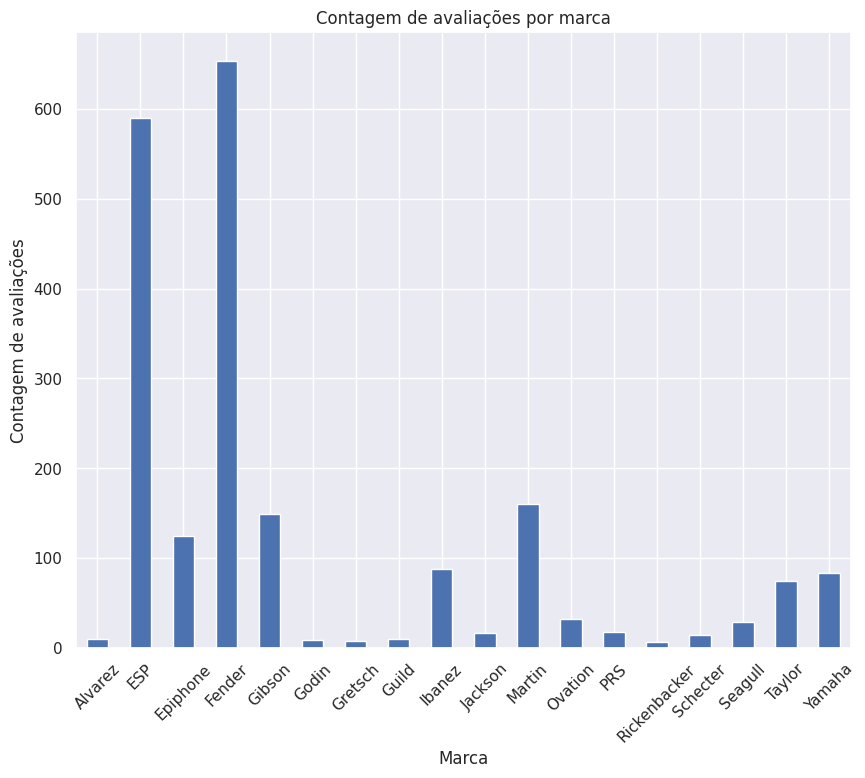

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o merged_df para um dataframe do pandas
df_pandas = merged_df.toPandas()

# agrupar por marca e contar a quantidade de avaliações
grouped_df = df_pandas.groupby('Marca')['Quantity'].sum()

# gerar o gráfico de barras
grouped_df.plot(kind='bar', rot=45, figsize=(10,8), title='Contagem de avaliações por marca')

# definir os rótulos dos eixos
plt.xlabel('Marca')
plt.ylabel('Contagem de avaliações')

# exibir o gráfico
plt.show()


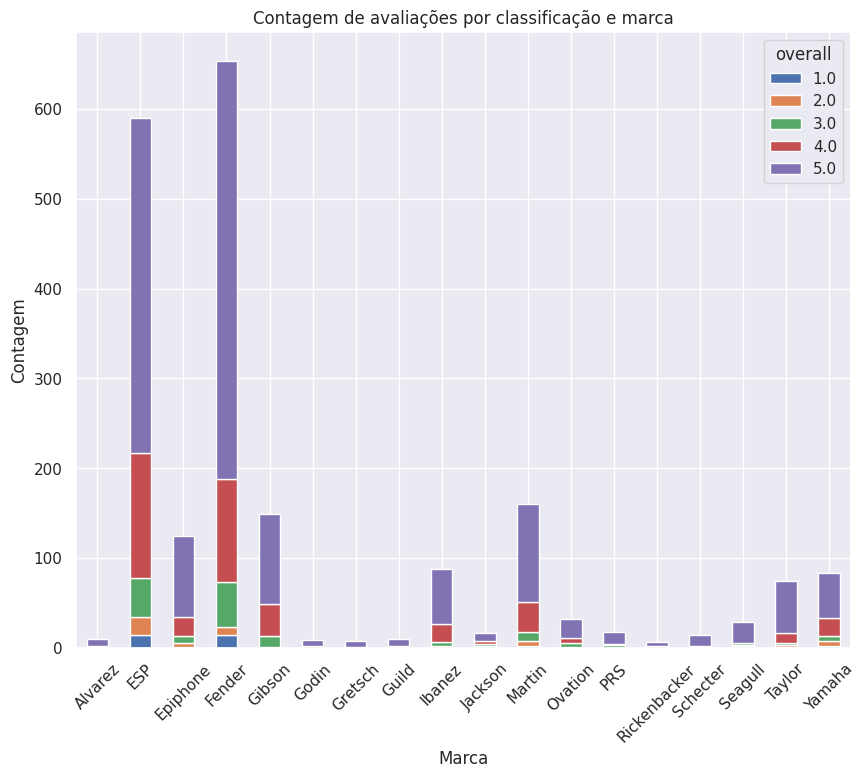

In [41]:
#Plotagem Gráfico
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o grouped_df para um dataframe do pandas
df_pandas = merged_df.toPandas()

# gerar o gráfico de barras empilhadas
df_pandas.pivot_table(index='Marca', columns='overall', values='Quantity').plot(kind='bar', stacked=True, rot=45, figsize=(10,8), 
                title='Contagem de avaliações por classificação e marca')

# definir os rótulos dos eixos
plt.xlabel('Marca')
plt.ylabel('Contagem')


# exibir o gráfico
plt.show()


# Série Temporal

In [61]:
df_1.show(2)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+-------+--------------+-------------------+----------+-----------+----------+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|summary|unixReviewTime|     reviewDateTime|reviewDate|reviewMonth|reviewYear|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+-------+--------------+-------------------+----------+-----------+----------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|   good|    1393545600|2014-02-28 00:00:00|2014-02-28|    2014-02|      2014|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|   Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|    2013-03|      2013|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+-------+--------------

In [62]:
#Reviews em série temporal #ANO-MES

spark.sql("""

SELECT  reviewMonth,
        COUNT(*) AS QTD

FROM df_1
GROUP BY reviewMonth
ORDER BY reviewMonth ASC
""").show()

+-----------+---+
|reviewMonth|QTD|
+-----------+---+
|    2004-09|  3|
|    2004-11|  3|
|    2004-12|  1|
|    2005-01|  1|
|    2005-03|  2|
|    2005-09|  1|
|    2006-01|  1|
|    2006-02|  1|
|    2006-03|  1|
|    2006-05|  2|
|    2006-06|  2|
|    2006-07|  1|
|    2006-10|  1|
|    2006-12|  1|
|    2007-01|  1|
|    2007-02|  1|
|    2007-03|  2|
|    2007-04|  1|
|    2007-09|  2|
|    2007-10|  4|
+-----------+---+
only showing top 20 rows



In [65]:
#Reviews em série temporal #ANO

spark.sql("""

SELECT  reviewMonth
        

FROM df_1

""").show()

+-----------+
|reviewMonth|
+-----------+
|    2014-02|
|    2013-03|
|    2013-08|
|    2014-02|
|    2014-02|
|    2012-12|
|    2014-01|
|    2012-11|
|    2008-07|
|    2014-01|
|    2012-04|
|    2014-04|
|    2013-11|
|    2013-06|
|    2012-12|
|    2013-08|
|    2013-08|
|    2013-07|
|    2013-03|
|    2013-08|
+-----------+
only showing top 20 rows



# Nuvem de Palavras

In [ ]:
from pyspark.sql.functions import regexp_replace, lower, split, explode, count

In [ ]:
df_1.show(4)

In [ ]:
# Criar um dataframe com a coluna "reviewText"
df = df_1.filter(df_1.overall == 5).select("reviewText")

# Remover caracteres especiais e transformar em minúsculas
df = df.withColumn("clean_text", regexp_replace(df["reviewText"], "[^a-zA-Z0-9\\s]", ""))
df = df.withColumn("clean_text", lower(df["clean_text"]))

# Dividir o texto em palavras
df = df.withColumn("words", split(df["clean_text"], "\\s+"))

# Transformar cada linha com várias palavras em várias linhas com uma única palavra
df = df.select(explode(df["words"]).alias("word"))

# Contar a frequência de cada palavra
word_counts = df.groupBy("word").agg(count("*").alias("count"))

# Ordenar o resultado em ordem decrescente de frequência
word_counts = word_counts.orderBy("count", ascending=False)

# Exibir as 10 palavras mais frequentes
word_counts.show(10)


In [ ]:
# Criar uma lista de palavras a serem removidas
retirar = ["i", "the", "a", "and", "to", "it", "is", "of", "for", "this", "in", "that", "with", "but", "was", "on", "my", "have", "had", "not", "at", "you", "are", "be", "as", "so", "if", "they", "can", "an", "or", "just", "like", "one", "out", "all", "about", "up", "there", "when", "from", "been", "would", "who", "which", "some", "more", "me", "its", "very", "dont", "than", "only", "do", "did", "could", "am", "no", "other", "her", "his", "he", "she", "we", "they", "them", "their", "our", "us", "because", "any", "will", "should", "must", "hadnt", "has", "have", "having", "how", "what", "where", "why", "when", "who", "whom", "which", "whose"]

# Aplicar o filtro para remover as palavras da lista "retirar"
word_counts = word_counts.filter(~word_counts.word.isin(retirar))

# Ordenar o resultado em ordem decrescente de frequência
word_counts = word_counts.orderBy("count", ascending=False)

# Exibir as 10 palavras mais frequentes
word_counts.show(30)

In [ ]:
#Piores notas e avaliacoes

In [ ]:
merged_df.filter("overall<=2").show()